In [ ]:
import pandas as pd
import numpy as np
import collections
import copy
import random
import matplotlib.pyplot as plt
import time
import multiprocessing
import nltk
import pickle
import hdbscan
import umap

from item.item_list import (
    ItemList,
    Item
)
from nlp.word_embeddings import (
    load_word_embeddings,
    get_item_embedding,
    get_items_embeddings
)

from nlp.preprocessing import (
    clean_text,
    preprocess,
    tokenize,
    preprocess_document,
    tokenize_document,
    get_stopwords, 
    lemmatization_document,
    get_canonical_words)

from nlp.pos_tagging import (
    get_tokens_tags
)
from item.spellcheckeropt import SpellcheckerOpt
from item.utils import get_tokens_set
from textpp_ptbr.preprocessing import TextPreProcessing as tpp

# Import xmeans through pyclustering library:
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer;
from pyclustering.cluster.xmeans import xmeans

# Import agglomerative clustering through scikit learn library:
from sklearn.cluster import AgglomerativeClustering

# Import agglomerative clustering through pyclustering library:
from pyclustering.cluster.agglomerative import agglomerative

# Import OPTICS through pyclustering library:
from pyclustering.cluster.optics import optics

# Import DBSCAN through pyclustering library:
from pyclustering.cluster.dbscan import dbscan

### pre processamento

In [78]:
#import nltk
#nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /dados01/workspace/ufmg.f01dcc/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
#REMOVENDO SERVICOS
#items_sem_servico = items[((items['unid_proc'].str.contains('serv')) 
#                            | (items['desc_proc'].str.contains('serv'))
#                            | (items['desc_proc'].str.contains('prest')))].shape

(60628, 14)

In [ ]:
#NO CODIGO DO TCU ELE TEM UMA ETAPA DE PRE PROCESSAMENTO QUE REMOVE
#PALAVRAS GENERICAS E UNIDADES DE MEDIDA SE ESTAS APARECEM NO INÍCIO DA DESCRICAO
#NAO SEI QUAL SERIA O REAL IMPACTO DISSO NO NOSSO PROBLEMA

#retira primeira palavra se estah em unidades ou primeira_palavra_generica:
# roda varias vezes pra tirar todas as primeiras palavras:
# for _ in range(3):
#     licitacon['DS_ITEM_CLEAN'] = licitacon['DS_ITEM_CLEAN'].apply(
#         lambda x: ' '.join(x.split()[1:]) \
#         if (len(x) > 1 \
#             and (x.split()[0] in unidades \
#             or x.split()[0] in primeira_palavra_generica)) else x )

In [ ]:
# count = 0
# stopwords_ = get_stopwords()
# not_str = 0

# for item in items_descriptions:
#     dsc_unidade = item[2]
#     if type(dsc_unidade) == str:
#         tokens = tokenize_document(dsc_unidade)
#         flag = False
#         for tok in tokens:
#             if tok == 'servico' or tok == 'prestacao':
#                 flag = True
#                 break
#         if flag:
#             count += 1
#     else:
#         not_str += 1

# count

In [56]:
#Criando a classe de items
#ao inves de armazenar a descricao original estou armazenando a descricao original tokenizada
#estou fazendo isso para implementar a versão original da proposta do TCU de fazer a media dos
#embeddinds ponderada pela posicao que o item aparece na descricao
#items_descriptions = items_sem_servico[['desc_token','vlr_unitario_homologado','unid_proc','desc_token']].values
#itemlist = ItemList()
#itemlist.load_items_from_list(items_descriptions)

# Initial test:

In [21]:
#  word embeddings file, each line contains an embedding
word_embeddings_file = '../../../embeddings/word2vec/cbow_s300.txt'

In [22]:
# read word embeddings from file and store them in a map
word_embeddings = load_word_embeddings(word_embeddings_file)

In [23]:
# It gets the descpitons processed:
itemlist = ItemList()
itemlist.load_items_from_file('../dados/items_preprocessed_sp0_sc1.zip', just_words=True)

In [ ]:
# It gets the descpitons processed:
#itemlistcomplete = ItemList()
#itemlistcomplete.load_items_from_file('../dados/items_preprocessed.zip', just_words=False)

In [24]:
itemlist.items_list[:2]

[['colagenase'], ['campo', 'operatorio']]

In [25]:
# Get all tokens 
items_words_complete = [x for x in itemlist.items_list]

In [104]:
#items_words_complete = [x.original for x in itemlist2.items_list]

In [12]:
items_words_complete[:5]

[['colagenase'],
 ['campo', 'operatorio'],
 ['kit', 'pet'],
 ['tinta', 'relevo', 'para', 'tecido', 'bran'],
 ['termometro',
  'clinico',
  'digital',
  'portatil',
  'para',
  'temperatura',
  'com',
  'leitura',
  'digital',
  'escala',
  'celsius']]

In [15]:
# Get the tags of tokens descriptions
word_class = get_tokens_tags()

In [29]:
# Build the vector representation for an item using the word embeddings
#TODO o que eh um embbeding_type??? seria a classe gramatical a ser usada?
def get_item_embedding_weighted(document, word_embeddings, word_class, embedding_type=None,
                       embedding_size=50):

    item_embedding = np.zeros(embedding_size)
    num_tokens = len(document)
    peso_acum = 0
    
    for pos,token in enumerate(document):
        if token in word_embeddings:
            peso = 1/(pos+1)
            if embedding_type == None:
                #media ponderada pela posicao
                #decresce linearmente                
                
                
                if token.isdigit():
                    #segundo a abordagem do tcu eles deixam os pesos de numeros em 
                    #3/4 da faixa de pesos
                    peso_digito = (1+(1/(len(document))))*(1/4)
                    item_embedding += peso_digito*np.array(word_embeddings[token])
                    peso_acum += peso_digito
                else:                
                    item_embedding += peso*np.array(word_embeddings[token])
                    peso_acum += peso
                    
            elif token in word_class and word_class[token] in set(embedding_type):
                item_embedding += peso*np.array(word_embeddings[token])
                peso_acum += peso
    if peso_acum != 0:
        item_embedding /= peso_acum

    return item_embedding

def get_items_embeddings_weighted(documents, word_embeddings, word_class, embedding_type=None,
                         embedding_size=50, type='list'):

    if type == 'list':
        documents_embeddings = []
    elif type == 'dict':
        documents_embeddings = {}

    id = 0
    for doc in documents:
        if type == 'list':
            documents_embeddings.append(list(get_item_embedding_weighted(doc, word_embeddings,
                                                    word_class, embedding_type
                                                    ,embedding_size)))
        elif type == 'dict':
            documents_embeddings[id] = list(get_item_embedding_weighted(doc, word_embeddings,
                                                    word_class, embedding_type
                                                    ,embedding_size))
        id += 1

    return documents_embeddings


In [30]:
len(word_embeddings['lapis'])

300

In [31]:
items_embeddings = get_items_embeddings_weighted(items_words_complete
                                                 , word_embeddings, word_class
                                                 ,embedding_type=['N', 'MED']
                                                 ,embedding_size=300
                                                ,type='list')

In [ ]:
# It gets the first tokens of each description and groups
# based on this approach:
#groups = itemlist.get_first_token_groups(just_words=True)

In [ ]:
# HDBSCAN

In [32]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import normalize, StandardScaler

sample_ids = random.sample(list(range(0,len(items_embeddings))),50000)            
sampled_items_emb = [items_embeddings[x] for x in sample_ids]

#scaler = StandardScaler()
#sampled_items_emb_norm = scaler.fit_transform(sampled_items_emb)                
sampled_items_emb_norm = normalize(sampled_items_emb, norm='l2')

#sampled_items_emb_dist = pairwise_distances(sampled_items_emb,metric='cosine')

In [37]:
#random.sample(list(range(0,len(items_embeddings))),50000) 
sample_ids2 = random.sample(list(range(0,50000)),500)            
len(sampled_items_emb_norm[sample_ids2])

500

In [40]:
np.array([[1,2,3,4],[3,4,15]])

array([list([1, 2, 3, 4]), list([3, 4, 15])], dtype=object)

In [ ]:
### Teste Reducao de dimensionalidade

In [ ]:

umap_redux = umap.UMAP(n_components=15
                       , random_state=999, metric='cosine',verbose=True)
umap_redux.fit(sampled_items_emb_norm) 
sampled_items_emb_norm = umap_redux.transform(X=sampled_items_emb_norm)

In [ ]:
hdb_clusterer = hdbscan.HDBSCAN(metric='euclidean',min_cluster_size=30
                            #,min_samples=1
                            ,prediction_data=True
                            ,core_dist_n_jobs=-1)
hdb_clusterer.fit(sampled_items_emb_norm)

In [ ]:
from collections import Counter
Counter(hdb_clusterer.labels_)
#items_words[sample_ids[x]] for x in hdb_clusterer.labels_ if x == 10]

In [108]:
samp_desc = [items_words_complete[x] for x in sample_ids]
df_teste = pd.DataFrame(data={'cluster':hdb_clusterer.labels_, 'desc':samp_desc})
df_teste.to_csv('../dados/resultados_teste_tcu/hdbscan_emb_50.csv',index=False,sep=';')

In [110]:
print(len(df_teste.cluster.unique()),' Clusters')

29  Clusters


In [97]:
sorted([" ".join(items_words_complete[sample_ids[pos]]) for pos,x in enumerate(hdb_clusterer.labels_) if x == -1])

['0 esfignomanometro infantil',
 '1 0 detergente liguido neutro 500 ml',
 '1 00 coco ralado desidratado de 100 gr',
 '1 00 gas de cozinha 13 kg recarga',
 '1 00 soja grao pcte c 500 grs',
 '1 004 pia de granito 2 00 mt',
 '1 0050 maderite cola branca 6 mm 1 10 x 2 20',
 '1 0054 cabo de bisturi inox n 3',
 '1 0056 azatioprina 50 mg similar',
 '1 0076 filtro para agua de barro com tampa',
 '1 0080 pano de chao',
 '1 0094 descartex 13 litros com 10 unidades',
 '1 0099 papel grau cirurgico 20 cm x 100 m',
 '1 0115 caixa organizadora de 20 litros',
 '1 0124 travessa de vidro com tampa grande',
 '1 0133 parafuso atarrachante 2 9 x 19',
 '1 0147 parafuso atarrachante 4 8 x 38',
 '1 0157 telha amianto 110 x 220',
 '1 0168 parafuso frances 1 2 x 6',
 '1 0169 cesto de lixo 15 litros sem tampa',
 '1 0169 fluido de freio 500 ml honoropolis',
 '1 0171 dimenidrato piridoxina 50 50 mg ml similar',
 '1 0200 escitalopram 10 mg similar',
 '1 021 tubo ponta azul',
 '1 0227 cabo elet 35 mm rolo 100 mt',
 

In [ ]:
# X-means clustering:

In [ ]:
# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 10
initial_centers = kmeans_plusplus_initializer(items_embeddings[:100], amount_initial_centers).initialize()

In [ ]:
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 20.
xmeans_instance = xmeans(items_embeddings[:100], initial_centers, 20, ccore=False)
xmeans_instance.process()

In [ ]:
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()

In [ ]:
clusters

In [ ]:
agglomerative = AgglomerativeClustering(n_clusters=20)
agglomerative.fit(items_embeddings)
clusters = agglomerative.labels_

In [ ]:
clusters

In [ ]:
# Visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.append_cluster(centers, None, marker='*', markersize=10)
visualizer.show()

In [ ]:
# It runs xmeans on the embeddings matrix and returns clusters:
def cluster_embeddings_by(embeddings_matrix, algorithm, kmax):

    if algorithm == 'xmeans':
        xmeans_instance = xmeans(embeddings_matrix, kmax=kmax, ccore=False)
        xmeans_instance.process()
        clusters = xmeans_instance.get_clusters()
    elif algorithm == 'agglomerative':
#         agglomerative = AgglomerativeClustering(n_clusters=kmax, affinity='cosine', linkage='complete')
#         agglomerative.fit(embeddings_matrix)
#         clusters = agglomerative.labels_
        agglomerative_instance = agglomerative(embeddings_matrix, number_clusters=kmax, ccore=False)
        agglomerative_instance.process()
        clusters = agglomerative_instance.get_clusters()
    elif algorithm == 'optics':
        radius = 0.4
        optics_instance = optics(embeddings_matrix, eps=radius, minpts=30, ccore=False)
        optics_instance.process()
        clusters = optics_instance.get_clusters()
    elif algorithm == 'dbscan':
        radius = 0.4
        dbscan_instance = dbscan(embeddings_matrix, eps=radius, neighbors=30, ccore=False)
        dbscan_instance.process()
        clusters = dbscan_instance.get_clusters()

    return clusters

In [ ]:
# Define the embedding matrix for a group:
def get_group_embeddings_matrix(group_desc, items_list, word_embeddings, word_class,
                                embedding_type=None, embedding_size=50):

    embeddings_matrix = []

    for desc_id in group_desc:
        item_embedding = get_item_embedding(items_list[desc_id], word_embeddings, word_class,
                                                embedding_type=embedding_type, embedding_size=embedding_size)
        embeddings_matrix.append(list(item_embedding))

    return embeddings_matrix

In [ ]:
def translate_id_to_descriptions(ids, descriptions_ids):
    arr = []

    for i in ids:
        arr.append(descriptions_ids[i])
    return arr

In [ ]:
def cluster_on_first_token_groups_emb(itemlist, first_token_groups, word_embeddings,
                                      word_class, embedding_type, it_thread, lower,
                                      upper, algorithm, embedding_size, Result):
    print(it_thread)

    # It creates a list of the the keys of these groups:
    groups = list(first_token_groups.keys())
    # It gets the values of each group (i.e., the ids of the descriptions into that group):
    group_descriptions = list(first_token_groups.values())

    # It defines the dictionary that will have the clustering with first token
    # together with x-means considering a the items embeddings
    # grouped by the first token approach:
    first_token_plus_emb_xmeans = {}
    # Iterator of the first token groups:
    ft_it = lower

    while ft_it <= upper:
        if(len(group_descriptions[ft_it]) > 30):
            embeddings_matrix = get_group_embeddings_matrix(group_descriptions[ft_it],
                                                            itemlist.items_list,
                                                            word_embeddings,
                                                            word_class, embedding_type,
                                                            embedding_size)

            #It applies the clusters on the embeddings matrix:
            kmax = len(group_descriptions[ft_it])/30
            clusters_embeddings = cluster_embeddings_by(embeddings_matrix,
                                                        algorithm=algorithm,
                                                        kmax=kmax)

#             if algorithm == 'agglomerative':
#                 cluster_items = collections.defaultdict(list)
#                 it = 0
#                 for desc_id in group_descriptions[ft_it]:
#                     cluster = clusters_embeddings[it]
#                     cluster_items[cluster].append(it)
#                     it += 1
#                 clusters_embeddings = [cluster_items[i] for i in range(0, len(cluster_items))]

            it = 0
            for c in clusters_embeddings:
                # It translates ids from x-means to actual descriptions (new groups):
                desc_ids = translate_id_to_descriptions(c, group_descriptions[ft_it])
                # It defines the key of the map:
                new_key = groups[ft_it] + '_' + str(it)
                # It sets the maps:
                first_token_plus_emb_xmeans[new_key] = desc_ids
                it = it + 1
        else:
            first_token_plus_emb_xmeans[groups[ft_it]] = group_descriptions[ft_it]
        ft_it = ft_it + 1

    Result[it_thread] = first_token_plus_emb_xmeans

In [ ]:
def get_ranges(group_len, n_threads):
    total_len = group_len
    num_threads = n_threads
    lower = []
    upper = []
    step = int(total_len/num_threads)

    for k in range(num_threads):
        lower.append(0)
        upper.append(0)

    lower[0] = 0
    upper[0] = step

    i = 1
    j = 0
    while (i < num_threads):
        upper[i]  = upper[j] + step
        lower[i]  = upper[j] +  1
        if(i%2 != 0):
            upper[i] = upper[i] + 1

        i = i + 1
        j = j + 1

    upper[n_threads - 1] = upper[n_threads - 1] - 6
    return lower, upper


In [ ]:
# It gets the descriptions processed:
itemlist = ItemList()
itemlist.load_items_from_file('../dados/items_preprocessed.zip', just_words=True)

In [ ]:
# Get the tags of tokens descriptions
word_class = get_tokens_tags()

In [ ]:
# It gets the first tokens of each description and groups
# based on this approach:
first_token_groups = itemlist.get_first_token_groups(just_words=True)
group_len = len(first_token_groups)

In [ ]:
first_token_groups_new = {}
keys_ft = list(first_token_groups.keys())
random.shuffle(keys_ft)
random.shuffle(keys_ft)

for k in keys_ft:
    first_token_groups_new[k] = first_token_groups[k]

In [ ]:
# word embeddings file, each line contains a word embedding
word_embeddings_file = '../../../embeddings/cbow_s50.txt'

In [ ]:
# read word embeddings from file and store them in a map
word_embeddings = load_word_embeddings(word_embeddings_file)

In [ ]:
manager = multiprocessing.Manager()
return_dict = manager.dict()
jobs = []
n_threads = 19

In [ ]:
# It defines the ranges (of the groups) the threads will work on:
thread_ranges = get_ranges(group_len, n_threads)
print('Read ranges')
print(thread_ranges)

In [ ]:
algorithm = 'dbscan'
embedding_size = 50

for i in range(n_threads):
    p = multiprocessing.Process(target=cluster_on_first_token_groups_emb,
    args = (itemlist, first_token_groups_new, word_embeddings, word_class, \
            ['N', 'MED'], i, thread_ranges[0][i], thread_ranges[1][i], algorithm, \
            embedding_size, return_dict))
    jobs.append(p)
    p.start()

In [ ]:
for proc in jobs:
    proc.join()

In [ ]:
len(return_dict)

In [ ]:
dictionary_clusters = {}
for i in range(n_threads):
    try:
        dictionary_clusters.update(return_dict[i])
    except:
        None

In [ ]:
a_file = open("./results/baseline+embeddings/embeddings50_SUB+MED_dbscan.pkl", "wb")
pickle.dump(dictionary_clusters, a_file)
a_file.close()

In [1]:
import pandas as pd
from collections import Counter

dft = pd.read_csv("../dados/resultados_teste_tcu/",sep=';')
dft.head(),dft.shape

(   cluster  item_id                                               desc
 0     1050        0                                     ['colagenase']
 1     1818        1                            ['campo', 'operatorio']
 2     8850        2                                     ['kit', 'pet']
 3       -1        3              ['tinta', 'relevo', 'tecido', 'bran']
 4       -1        4  ['termometro', 'clinico', 'digital', 'portatil...,
 (1508992, 3))

In [29]:
dft.loc[3]['desc']

"['tinta', 'relevo', 'tecido', 'bran']"

In [23]:
Counter(dft.cluster)

Counter({1050: 142,
         1818: 166,
         8850: 687,
         -1: 383426,
         3677: 468,
         2595: 242,
         1516: 439,
         578: 150,
         4022: 669,
         4829: 61,
         4710: 685,
         2548: 829,
         6861: 598,
         8571: 65,
         5573: 171,
         6603: 110,
         8540: 94,
         3550: 116,
         6086: 229,
         8314: 1950,
         1245: 99,
         33: 91,
         1028: 2254,
         8614: 1364,
         2: 67050,
         6414: 661,
         2554: 455,
         3662: 85,
         4589: 45,
         3234: 49,
         342: 157,
         2045: 496,
         2543: 821,
         7593: 268,
         3468: 167,
         5655: 842,
         442: 422,
         1425: 215,
         6947: 55,
         7772: 181,
         415: 595,
         1147: 462,
         6457: 46,
         8054: 310,
         1177: 126,
         453: 41,
         5585: 30,
         1738: 1919,
         3629: 951,
         2862: 3998,
         7469:

In [35]:
df_aux = dft[dft.cluster==-1]
#descs = list(map(lambda x: x.replace('[','').replace(']','').split(','),df_aux.desc.values))
#descs[:2]
df_aux.to_csv('../dados/outliers_from_hdbscan_emb50_samp100_size30_dimfull.csv'
              ,sep=';',index=False)

In [26]:
dft[dft.desc.str.contains('consolo')],dft[dft.desc.str.contains('consolo')].shape

(         cluster  item_id                                               desc
 857274      3485   857274  ['bancar', 'granito', 'andorinha', 'consolo', ...
 972763        -1   972763                         ['a3523200278', 'consolo']
 1134483     3485  1134483  ['bancar', 'granito', 'andorinha', 'consolo', ...
 1197379       -1  1197379                         ['a3523200278', 'consolo']
 1200897       -1  1200897                         ['a3523200278', 'consolo']
 1342585     3485  1342585  ['bancar', 'granito', 'andorinha', 'consolo', ...,
 (6, 3))

In [2]:
# for x in dft[(dft.desc.str.contains('campo'))
#             & (dft.desc.str.contains('operatorio') )
#             & (dft.cluster == -1)].desc:
#     print(x)


['campo', 'operatorio', '45', 'cm', 'x', '50', 'cm']
['compressa', 'de', 'campo', 'operatorio', 'sem', 'radiopaco', 'medindo', '45', 'x', '50', 'constituido', 'de', '4', 'camadas', 'de', 'gaze', 'sobreposta', 'contendo', '15', '8', 'x', '7', 'fios', 'por', 'cm2', 'aproximadamente', 'em', 'cada', 'camada', 'cor', 'branca', 'bordas', 'devidamente', 'acabadas', 'atraves', 'do', 'ponto', 'overloque', 'formato', 'retangular', 'provido', 'de', 'alca', 'cantos', 'arredondados', 'peso', '41', '40', 'g', 'embaladaem', 'pacote', 'com', '50', 'pecas', 'com', 'registro', 'no', 'm', 's']
['campo', 'operatorio', '23', 'x', '25']
['compressa', 'cirurgica', 'campo', 'operatorio', 'nao', 'esteril', '45', 'cm', 'x', '50', 'cm']
['campo', 'operatorio', '23', 'x', '25', 'c', '50']
['compressa', 'cirurgica', 'campo', 'operatorio', '25', 'x', '25', 'cm', 'c', '50', 'und']
['compressa', 'de', 'gaze', 'cirurgica', '100', 'algodao', 'tamanho', '25', 'x', '23', 'cm', 'campo', 'operatorio', 'sem', 'fio', 'radiop

In [19]:
df_samp = dft.sample(frac=0.002)
df_samp.shape

(3336, 2)

In [20]:
import numpy as np
from sklearn.manifold import TSNE
emb_2_plot = get_items_embeddings_weighted(df_samp.desc.values, word_embeddings, None)

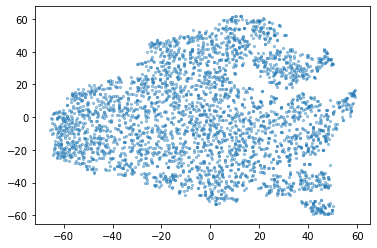

In [21]:
projection = TSNE().fit_transform(emb_2_plot)
plt.scatter(*projection.T, s = 5, alpha=0.4)

In [11]:
xxx = [[1,2,3],[5,3,2]]
set([x for xx in xxx for x in xx ])

{1, 2, 3, 5}